In [74]:
import ipyparallel as ipp

rc = ipp.Client()
dview = rc[:]

rc.ids

/home/hegder/anaconda3/lib/python3.7/site-packages/ipyparallel/client/client.py:459: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@Gamma')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


[0, 1, 2, 3, 4, 5, 6, 7]

In [75]:
%%px --local
%load_ext autoreload
%autoreload 2

import numpy as np
import mxnet as mx
#import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
# # # #import jtplot submodule from jupyterthemes
# # # from jupyterthemes import jtplot
# # # #currently installed theme will be used to
# # # #set plot style if no arguments provided
# # # jtplot.style()

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2_v2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]

#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
# normalize inputs 
#x_test = (x_test - 50)/20 

print("Dataset has been loaded")



# # Step1: Load the model in MXNet

# # # Use the same prefix and epoch parameters we used in save_mxnet_model API.
sym, arg_params, aux_params = mx.model.load_checkpoint(prefix='./models/my_mod_convprel', epoch=0)

# We use the data_names and data_shapes returned by save_mxnet_model API.
mod = mx.mod.Module(symbol=sym, 
                    data_names=['/first_input6'], 
                    context=mx.gpu(), 
                    label_names=None)
mod.bind(for_training=False, 
         data_shapes=[('/first_input6', (1,8))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)    


#resnet - my_mod_bet   input_21
#fullycon - my_mod_fullycon  first_input2
#conv1d - my_mod_conv1d - first_input4
#convprel - my_mod_convprel - first_input6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Dataset has been loaded
[stdout:0] Dataset has been loaded
[stdout:1] Dataset has been loaded
[stdout:2] Dataset has been loaded
[stdout:3] Dataset has been loaded
[stdout:4] Dataset has been loaded
[stdout:5] Dataset has been loaded
[stdout:6] Dataset has been loaded
[stdout:7] Dataset has been loaded


In [77]:

%%px --local
%load_ext autoreload
%autoreload 2


#%%px --local
import time
import de2 as de
import loss_defs as ld

bnds = [(30, 70)]*8
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
lams = np.linspace(300, 1200, 256)
targ_spec = y_test[29]


from sklearn.model_selection import ParameterGrid
param_grid = {
    'psize': [80, 160, 320], 
    'psnew': [20, 40],
    'crossp': [0.4, 0.5, 0.6, 0.7, 0.8]
      }
grid = ParameterGrid(param_grid) 

def dE_stat(psize,psnew,its_first,its_second,mut,crossp):
    return psize, psnew, crossp


def de_stat(psize,psnew,its_first,its_second,mut,crossp):
    run_time_tot = []
    run_pmre = []
    reps = 20
    targ_spec2 = np.tile(targ_spec, (psize,1))
    for rep in range(reps):
#         print(rep)
        start = time.time()
        pop, f, b, hstry = de.de_g(
            fobj=ld.mxmod_arr_loss, 
            bounds=bnds, 
            mut=mut,
            crossp=crossp,
            popsize=psize, 
            its=its_first, 
            target=targ_spec2, 
            mxmodel=mod) 
        marg = int(psnew/5)
        pnew1 = pop[np.argsort(f)][:psnew-marg]
        pnew2 = pop[np.argsort(f)][psnew-marg:psnew]
        pnew = np.concatenate((pnew1, pnew2))
        b, c, hstry = de.de_c(
            fobj=ld.loss_func, 
            bounds=bnds, 
            pop=pnew, 
            history=hstry, 
            it_start=its_first, 
            mut=mut,
            crossp=crossp,
            popsize=psnew, 
            its=its_second, 
            target=targ_spec, 
            mats=mats, 
            lams=lams)
        end = time.time()
        run_time_tot.append((end - start)/60.0)
        run_pmre.append(c)
    return  np.mean(run_pmre), np.std(run_pmre), np.mean(run_time_tot)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:0] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:1] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:2] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:3] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:4] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:5] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:6] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[stdout:7] 
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:

def ff(x):
    for pset in grid:
#         print(x,pset)
        pm, pstd, rmd = de_stat(psize=pset['psize'],
                                psnew=pset['psnew'],
                                its_first=500,
                                its_second=300,
                                mut=x,
                                crossp=pset['crossp']
                               )
        print(pm)
        print(pstd)
        print(rmd)
    

 
#asyn = dview.map_async(ff,[0.5 ,0.6, 0.7, 0.8, 0.9, 1.0])
#ff(0.5)

In [143]:


outs=[]
for out in asyn.stdout:
    outs.append(out.splitlines())

outs2 = sum(outs, [])

outs_f = np.array([float(o)  for o in outs2])
outs_f

a =np.reshape(outs_f, (int(outs_f.size/3),3))
pm = a[:,0]
pstd = a[:,1]
rmd = a[:,2]


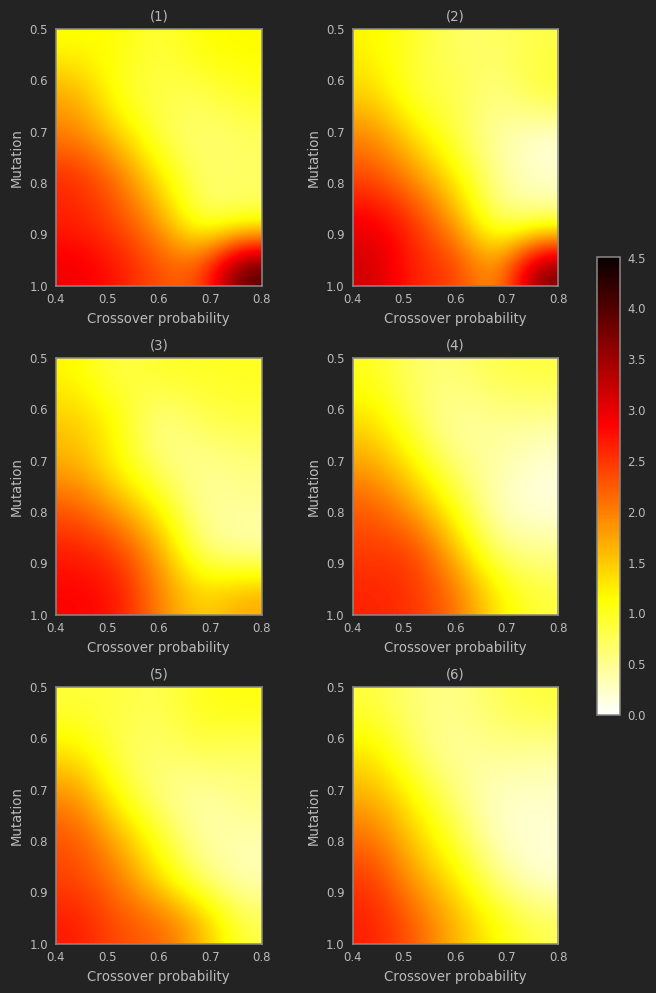

In [240]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(grid=False, fscale=0.8)
#jtplot.reset()

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,10))
for idx, ax in enumerate(axes.flat):
     im = ax.imshow(np.reshape(pm[idx::6], (6,5)), interpolation='bicubic', extent=[0.4, 0.8, 1.0, 0.5], 
                    vmin=0, vmax=4.5, cmap="hot_r")
     ax.set_xlabel('Crossover probability')
     ax.set_ylabel('Mutation')
     ax.set_title('(' + str(idx+1) + ')')
plt.tight_layout()     

fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)

#plt.savefig('de_hyps_pm.pdf')


In [241]:
import time
import de2 as de
import loss_defs as ld

bnds = [(30, 70)]*8
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
lams = np.linspace(300, 1200, 256)
targ_spec = y_test[29]

psize = 320
targ_spec2 = np.tile(targ_spec, (psize,1))
its_first = 500
psnew = 20
its_second = 300
reps = 100


run_hist = []
run_time1 = []
run_time2 = []
run_time_tot = []
run_pmre = []
run_best = []

for rep in range(reps):
    print("iteration ", rep)
    start = time.time()
    pop, f, b, hstry = de.de_g(fobj=ld.mxmod_arr_loss, bounds=bnds, popsize=psize, its=its_first, target=targ_spec2, mxmodel=mod) 
    #pop, f, b, hstry = de2(fobj=mxmod_arr_loss, bounds=bnds, popsize=psize, its=its_first) 
    end1 = time.time()
    marg = int(psnew/5)
    pnew1 = pop[np.argsort(f)][:psnew-marg]
    pnew2 = pop[np.argsort(f)][psnew-marg:psnew]
    pnew = np.concatenate((pnew1, pnew2))
    #b, c, hstry = de_stage2(fobj=loss_func, bounds=bnds, popint=pnew, history=hstry, itprev=its_first, popsize=psnew, its=its_second)
   # b, c, hstry = de.de_c(fobj=loss_func, bounds=bnds,  popsize=80, its=500)
    b, c, hstry = de.de_c(fobj=ld.loss_func, bounds=bnds, pop=pnew, history=hstry, it_start=its_first, popsize=psnew, its=its_second, target=targ_spec, mats=mats, lams=lams)
    end = time.time()
    run_time1.append((end1 - start)/60.0)
    run_time2.append((end - end1)/60.0)
    run_time_tot.append((end - start)/60.0)
    run_pmre.append(c)
    run_best.append(b)
    run_hist.append(np.asarray(hstry))


iteration  0
iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
iteration  11
iteration  12
iteration  13
iteration  14
iteration  15
iteration  16
iteration  17
iteration  18
iteration  19
iteration  20
iteration  21
iteration  22
iteration  23
iteration  24
iteration  25
iteration  26
iteration  27
iteration  28
iteration  29
iteration  30
iteration  31
iteration  32
iteration  33
iteration  34
iteration  35
iteration  36
iteration  37
iteration  38
iteration  39
iteration  40
iteration  41
iteration  42
iteration  43
iteration  44
iteration  45
iteration  46
iteration  47
iteration  48
iteration  49
iteration  50
iteration  51
iteration  52
iteration  53
iteration  54
iteration  55
iteration  56
iteration  57
iteration  58
iteration  59
iteration  60
iteration  61
iteration  62
iteration  63
iteration  64
iteration  65
iteration  66
iteration  67
iteration  68
iteration  69
iteration  70
iteration  71
it

In [ ]:
pm, pstd, rm, rstd

In [ ]:
# import jtplot module in notebook
from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
#jtplot.style(theme='monokai')

# set "context" (paper, notebook, talk, poster)
# scale font-size of ticklabels, legend, etc.
# remove spines from x and y axes and make grid dashed
#jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')

# turn on X- and Y-axis tick marks (default=False)
# turn off the axis grid lines (default=True)
# and set the default figure size
#jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))
jtplot.style(grid=False, figsize=(4,2), fscale=0.7, s)
# reset default matplotlib rcParams
#jtplot.reset()
plt.s
plt.hist(run_pmre, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 2.5, 3], density=True, stacked=True)

In [ ]:
fig, ax = plt.subplots()
ax.hist(run_pmre, bins=np.linspace(0, 2, 33), density=True, stacked=True, histtype='stepfilled')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(left=0.0)
#ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)